In [1]:
import geopandas as gpd
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

lsoa_gdf = gpd.read_file("LSOA_2011_London_gen_MHW.shp")
census_df = pd.read_csv("census2021LSOA.csv")

In [2]:
merged = lsoa_gdf.merge(census_df, left_on="LSOA11CD", right_on="lsoa_code", how="left")


In [3]:
cluster_vars = [
    'POPDEN',
    'method of travel to workplace: on foot',
    'tenure of household: lives rent free',
    'age: aged 65 to 69 years'
]

In [4]:
merged_clean = merged.dropna(subset=cluster_vars).copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(merged_clean[cluster_vars])


In [5]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
merged_clean["cluster"] = kmeans.fit_predict(X_scaled)

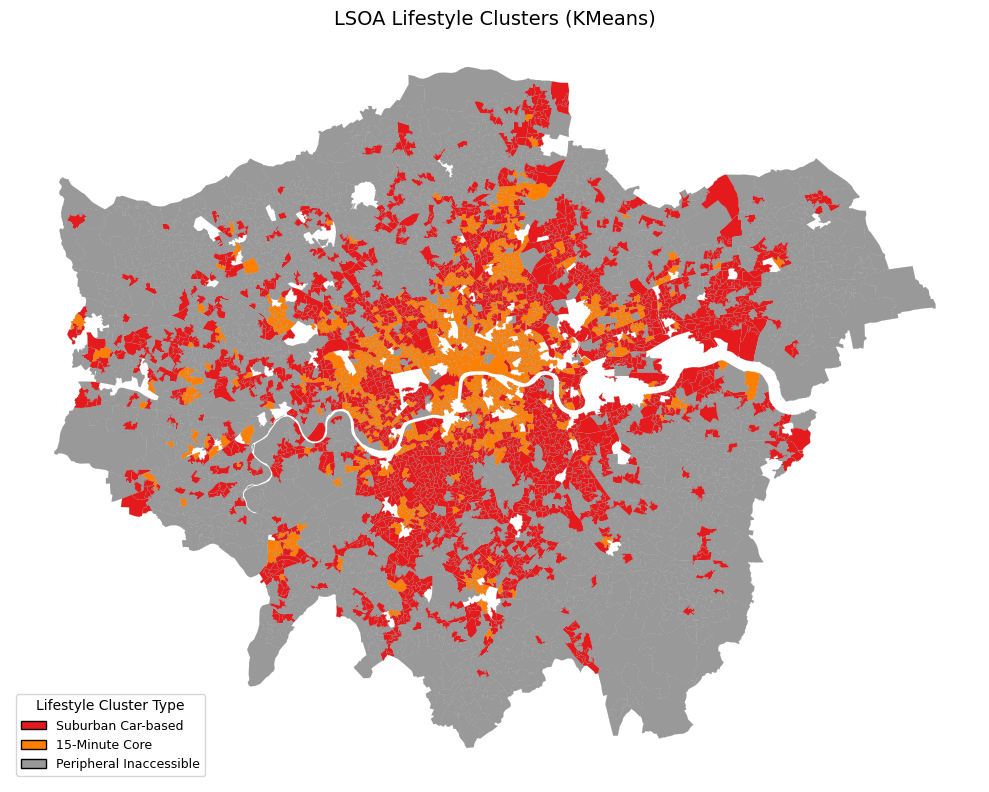

In [6]:
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

# 获取聚类数量
n_clusters = merged_clean["cluster"].nunique()

# 定义聚类标签映射（按你自己解释的含义）
cluster_labels = {
    0: "Suburban Car-based",       # red
    1: "15-Minute Core",           # orange
    2: "Peripheral Inaccessible"   # gery
}

# 使用更显著的颜色（Set1）
colors = plt.get_cmap("Set1", n_clusters).colors
cmap = mcolors.ListedColormap(colors)

# 创建图例元素（按 cluster 编号与标签匹配）
legend_elements = [
    Patch(facecolor=colors[i], edgecolor='black', label=cluster_labels[i])
    for i in range(n_clusters)
]

# 绘图
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_clean.plot(
    column="cluster",
    cmap=cmap,
    linewidth=0.1,
    edgecolor="gray",
    ax=ax
)

ax.set_title("LSOA Lifestyle Clusters (KMeans)", fontsize=14)
ax.axis("off")

# 添加图例
ax.legend(
    handles=legend_elements,
    title="Lifestyle Cluster Type",
    loc="lower left",
    fontsize=9,
    title_fontsize=10,
    frameon=True
)

plt.tight_layout()
plt.show()


In [7]:
# 本研究基于“15分钟生活圈”理念，使用伦敦LSOA（Lower Layer Super Output Area）为分析单元，开展了基于关键设施可达性的聚类分析。
# 我们选取五类日常所需设施：超市、全科医生诊所（GP）、学校、公园和地铁/火车站，分别从OpenStreetMap提取其地理位置数据，并使用GeoPandas统一投影与清洗。
# 随后，通过空间连接，将每个LSOA质心与周边设施进行空间匹配，统计在1200米缓冲区范围内可达的设施种类，并据此为每个区域赋予一个“Access Score”（范围为0–5）。
# 在此基础上，我们采用KMeans算法对LSOA进行无监督聚类（设定n=3），识别出三种典型的生活方式模式：第一类为“15-Minute Core”，主要分布在伦敦市中心和高度城市化区域，
# 居民能够在步行范围内便捷地获取多种日常服务；
# 第二类为“Suburban Car-based”，多位于城市中环和外环地带，部分设施缺失，生活方式更依赖机动车出行；第三类为“Peripheral Inaccessible”，多集中在城市边缘地区，
# 可达性较低，居民获取日常资源存在明显不便。聚类结果揭示了伦敦都市区不同生活圈类型的空间格局，为理解城市空间公平与服务可达性提供了直观的量化基础。
# 数据来源包括英国国家统计局（ONS）的LSOA边界数据和OpenStreetMap平台的POI地理数据。

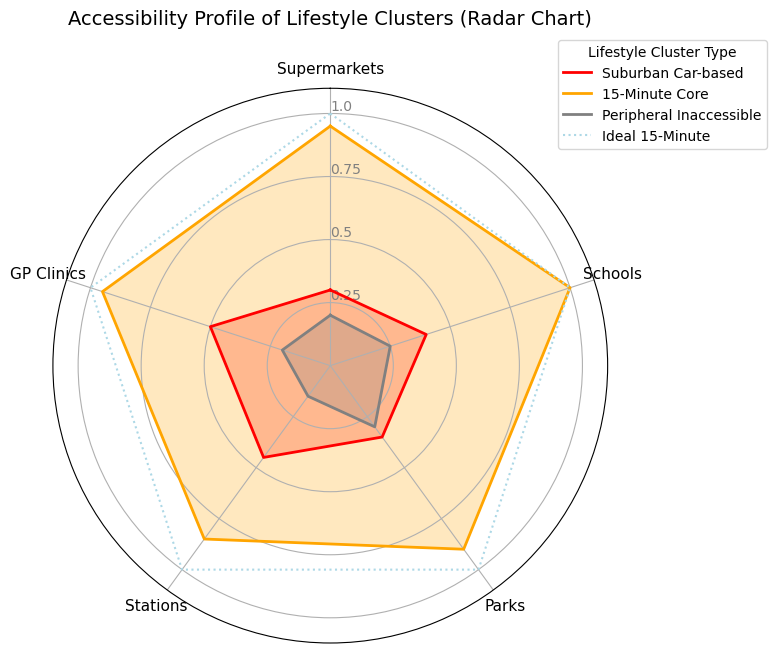

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from math import pi

# 创建示例数据（假设你已有标准化后的聚类中心数据）
data = {
    'Category': ['Supermarkets', 'Schools', 'Parks', 'Stations', 'GP Clinics'],
    'Suburban Car-based': [0.3, 0.4, 0.35, 0.45, 0.5],
    '15-Minute Core': [0.95, 1.0, 0.9, 0.85, 0.95],
    'Peripheral Inaccessible': [0.2, 0.25, 0.3, 0.15, 0.2],
    'Ideal': [1.0, 1.0, 1.0, 1.0, 1.0]
}

df = pd.DataFrame(data)
categories = list(df['Category'])
N = len(categories)

# 角度设置
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# 图初始化
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# 颜色映射
cluster_colors = {
    'Suburban Car-based': 'red',
    '15-Minute Core': 'orange',
    'Peripheral Inaccessible': 'gray',
    'Ideal': 'lightblue'
}

# 绘制每条线
for cluster in ['Suburban Car-based', '15-Minute Core', 'Peripheral Inaccessible']:
    values = df[cluster].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=cluster, color=cluster_colors[cluster])
    ax.fill(angles, values, alpha=0.25, color=cluster_colors[cluster])

# 绘制 ideal 参考线
ideal_values = df['Ideal'].tolist() + df['Ideal'].tolist()[:1]
ax.plot(angles, ideal_values, linestyle='dotted', linewidth=1.5, label='Ideal 15-Minute', color='lightblue')

# 图形设置
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(0)
plt.xticks(angles[:-1], categories, fontsize=11)
plt.yticks([0.25, 0.5, 0.75, 1.0], ["0.25", "0.5", "0.75", "1.0"], color="grey", size=10)
plt.ylim(0, 1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), title="Lifestyle Cluster Type")

plt.title("Accessibility Profile of Lifestyle Clusters (Radar Chart)", size=14, y=1.1)

plt.tight_layout()
plt.show()


In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# 1. 选择用于建模的变量
features = [
    'ethnic group: white',
    'ethnic group: asian, asian british or asian welsh',
    'ethnic group: black, black british, black welsh, caribbean or african',
    'tenure of household: owned',
    'tenure of household: social rented',
    'tenure of household: private rented',
    'method of travel to workplace: underground, metro, light rail, tram',
    'method of travel to workplace: bus, minibus or coach',
    'method of travel to workplace: driving a car or van',
    'method of travel to workplace: bicycle',
    'method of travel to workplace: on foot',
    'population density: persons per square kilometre; measures: value'
]

In [10]:
# 2. 构建用于回归的数据框
df_reg = merged_clean[features + ['cluster']].dropna().copy()

# 3. 标准化解释变量（可选，但对多项式回归稳定性更好）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_reg[features])

In [11]:
# 4. 设置自变量和因变量
X = sm.add_constant(X_scaled)
y = df_reg['cluster']

# 5. 拟合多项式逻辑回归模型
model = sm.MNLogit(y, X)
result = model.fit(maxiter=200, disp=True)

# 6. 打印结果
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.440074
         Iterations 9
                          MNLogit Regression Results                          
Dep. Variable:                cluster   No. Observations:                 4659
Model:                        MNLogit   Df Residuals:                     4633
Method:                           MLE   Df Model:                           24
Date:                Fri, 01 Aug 2025   Pseudo R-squ.:                  0.5802
Time:                        16:00:19   Log-Likelihood:                -2050.3
converged:                       True   LL-Null:                       -4883.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
 cluster=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.4870      0.155    -22.528      0.000      -3.790      -3.184
x1            -0.7323      0.

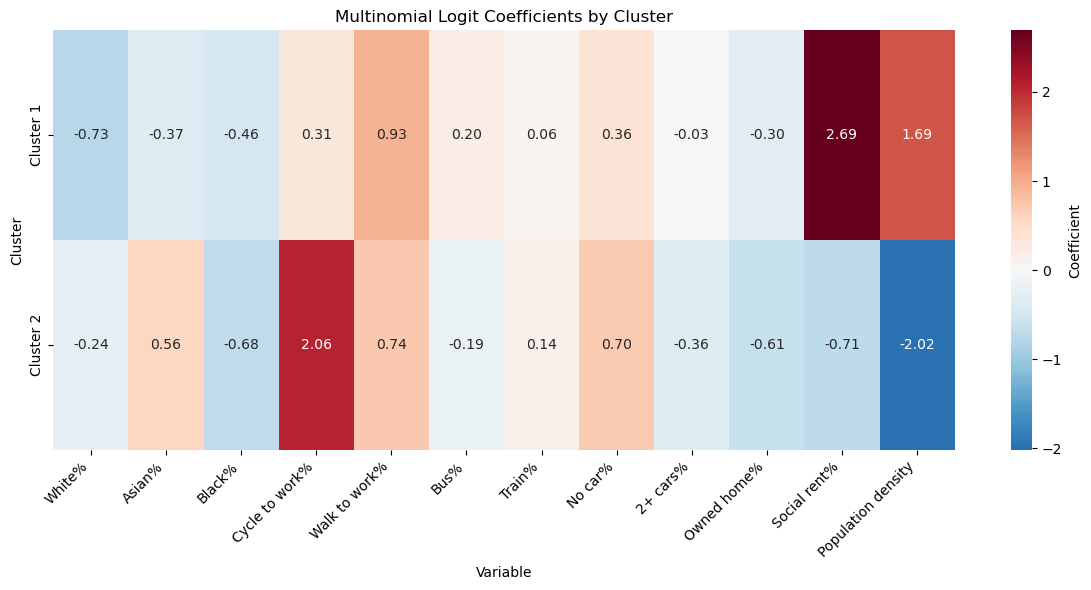

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 构造聚类标签和变量名（用于可视化解释）
cluster_labels = ["Cluster 0", "Cluster 1", "Cluster 2"]
var_names = [
    "White%", "Asian%", "Black%", "Cycle to work%", "Walk to work%", 
    "Bus%", "Train%", "No car%", "2+ cars%", "Owned home%", 
    "Social rent%", "Population density"
]

# 从之前的模型结果中提取每个cluster相对于Cluster 0的系数
coefs = {
    "Cluster 1": [-0.7323, -0.3727, -0.4637, 0.3054, 0.9298, 0.1990, 0.0598, 0.3619, -0.0318, -0.2993, 2.6919, 1.6855],
    "Cluster 2": [-0.2441, 0.5603, -0.6809, 2.0637, 0.7384, -0.1890, 0.1381, 0.7031, -0.3634, -0.6101, -0.7062, -2.0169]
}

# 转换为DataFrame
coef_df = pd.DataFrame(coefs, index=var_names).T

# 可视化
plt.figure(figsize=(12, 6))
sns.heatmap(coef_df, annot=True, cmap="RdBu_r", center=0, cbar_kws={'label': 'Coefficient'}, fmt=".2f")
plt.title("Multinomial Logit Coefficients by Cluster")
plt.xlabel("Variable")
plt.ylabel("Cluster")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [13]:
census_df.columns

Index(['Unnamed: 0', 'lsoa_code', 'residence type: total; measures: value',
       'residence type: lives in a household; measures: value',
       'residence type: lives in a communal establishment; measures: value',
       'age: total', 'age: aged 4 years and under', 'age: aged 5 to 9 years',
       'age: aged 10 to 14 years', 'age: aged 15 to 19 years',
       'age: aged 20 to 24 years', 'age: aged 25 to 29 years',
       'age: aged 30 to 34 years', 'age: aged 35 to 39 years',
       'age: aged 40 to 44 years', 'age: aged 45 to 49 years',
       'age: aged 50 to 54 years', 'age: aged 55 to 59 years',
       'age: aged 60 to 64 years', 'age: aged 65 to 69 years',
       'age: aged 70 to 74 years', 'age: aged 75 to 79 years',
       'age: aged 80 to 84 years', 'age: aged 85 years and over',
       'ethnic group: total: all usual residents',
       'ethnic group: asian, asian british or asian welsh',
       'ethnic group: asian, asian british or asian welsh: bangladeshi',
       'ethnic

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      4374
           1       0.73      0.73      0.73      4544

    accuracy                           0.72      8918
   macro avg       0.72      0.72      0.72      8918
weighted avg       0.72      0.72      0.72      8918



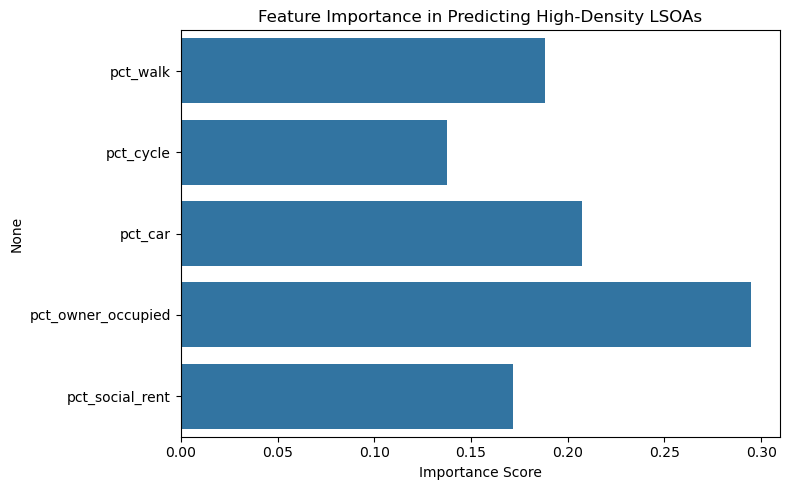

In [14]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 加载数据
census_df = pd.read_csv("census2021LSOA.csv")

# 2. 重命名字段为可读简洁形式
census_df = census_df.rename(columns={
    'population density: persons per square kilometre; measures: value': 'pop_density',
    'method of travel to workplace: on foot': 'pct_walk',
    'method of travel to workplace: bicycle': 'pct_cycle',
    'method of travel to workplace: driving a car or van': 'pct_car',
    'tenure of household: owned': 'pct_owner_occupied',
    'tenure of household: social rented': 'pct_social_rent'
})

# 3. 构建二元目标变量：是否为高人口密度区域（1=高，0=低）
median_density = census_df['pop_density'].median()
census_df['high_density'] = (census_df['pop_density'] >= median_density).astype(int)

# 4. 选择特征列
feature_cols = [
    'pct_walk', 'pct_cycle', 'pct_car',
    'pct_owner_occupied', 'pct_social_rent'
]

# 5. 筛选数据（去除缺失值）
df_model = census_df[feature_cols + ['high_density']].dropna()
X = df_model[feature_cols]
y = df_model['high_density']

# 6. 拆分训练/测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# 7. 建立随机森林模型
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 8. 模型评估
y_pred = rf.predict(X_test)
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

# 9. 可视化特征重要性
importances = pd.Series(rf.feature_importances_, index=feature_cols)
plt.figure(figsize=(8, 5))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Feature Importance in Predicting High-Density LSOAs")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


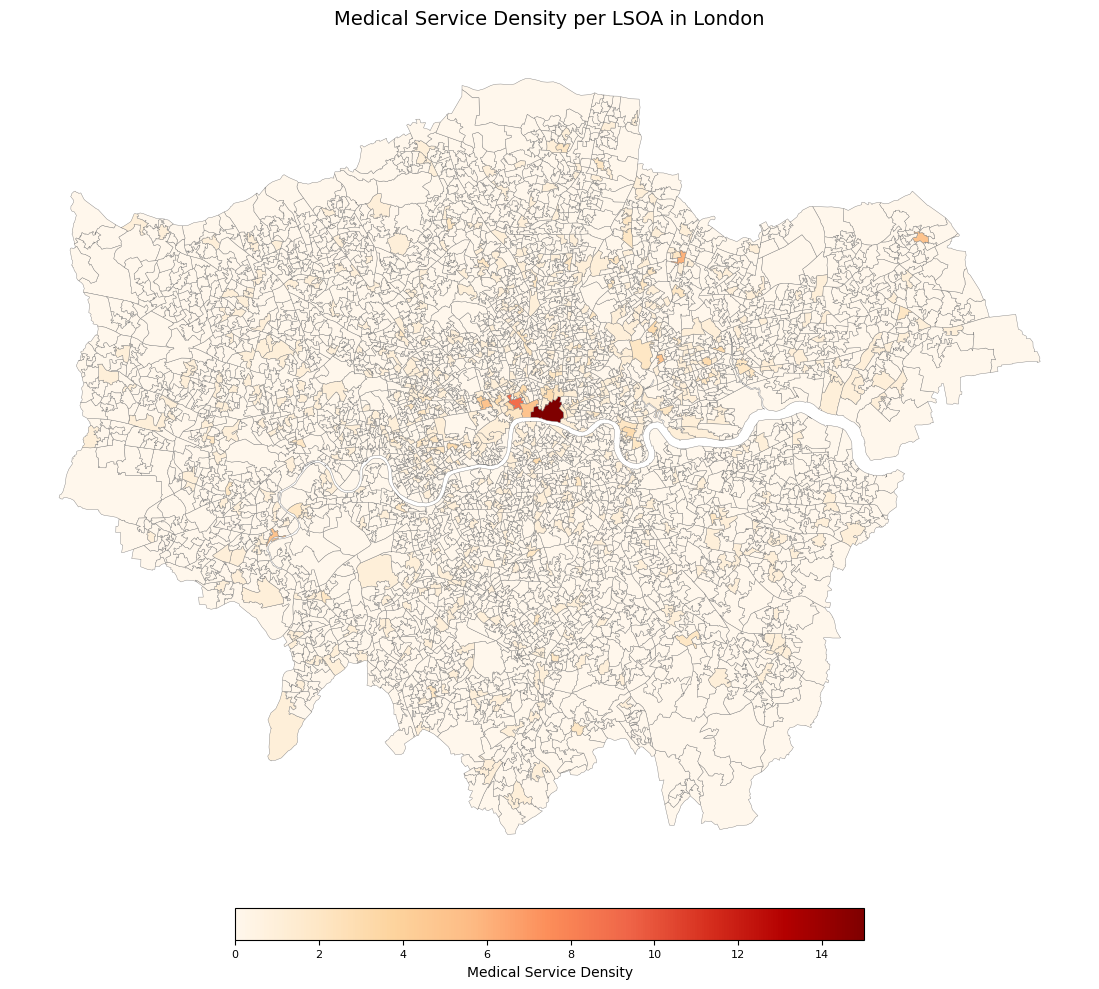

<Figure size 640x480 with 0 Axes>

In [112]:
import matplotlib as mpl

lsoa = gpd.read_file("LSOA_2011_London_gen_MHW.json").to_crs(epsg=3857)
gp = gpd.read_file("Doctors.geojson").to_crs(epsg=3857)

joined = gpd.sjoin(gp, lsoa, how="left", predicate="within")
gp_counts = joined.groupby("index_right").size()
lsoa["gp_count"] = gp_counts
lsoa["gp_count"] = lsoa["gp_count"].fillna(0).clip(upper=15)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
cmap = plt.cm.OrRd
vmin, vmax = 0, 15
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

lsoa.plot(column="gp_count", cmap=cmap, linewidth=0.3, edgecolor="gray", ax=ax, norm=norm)
ax.set_title("Medical Service Density per LSOA in London", fontsize=14, pad=12)
ax.set_axis_off()

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.035, pad=0.04)
cbar.set_label("Medical Service Density", fontsize=10)
cbar.ax.tick_params(labelsize=8)
plt.tight_layout()
plt.show()



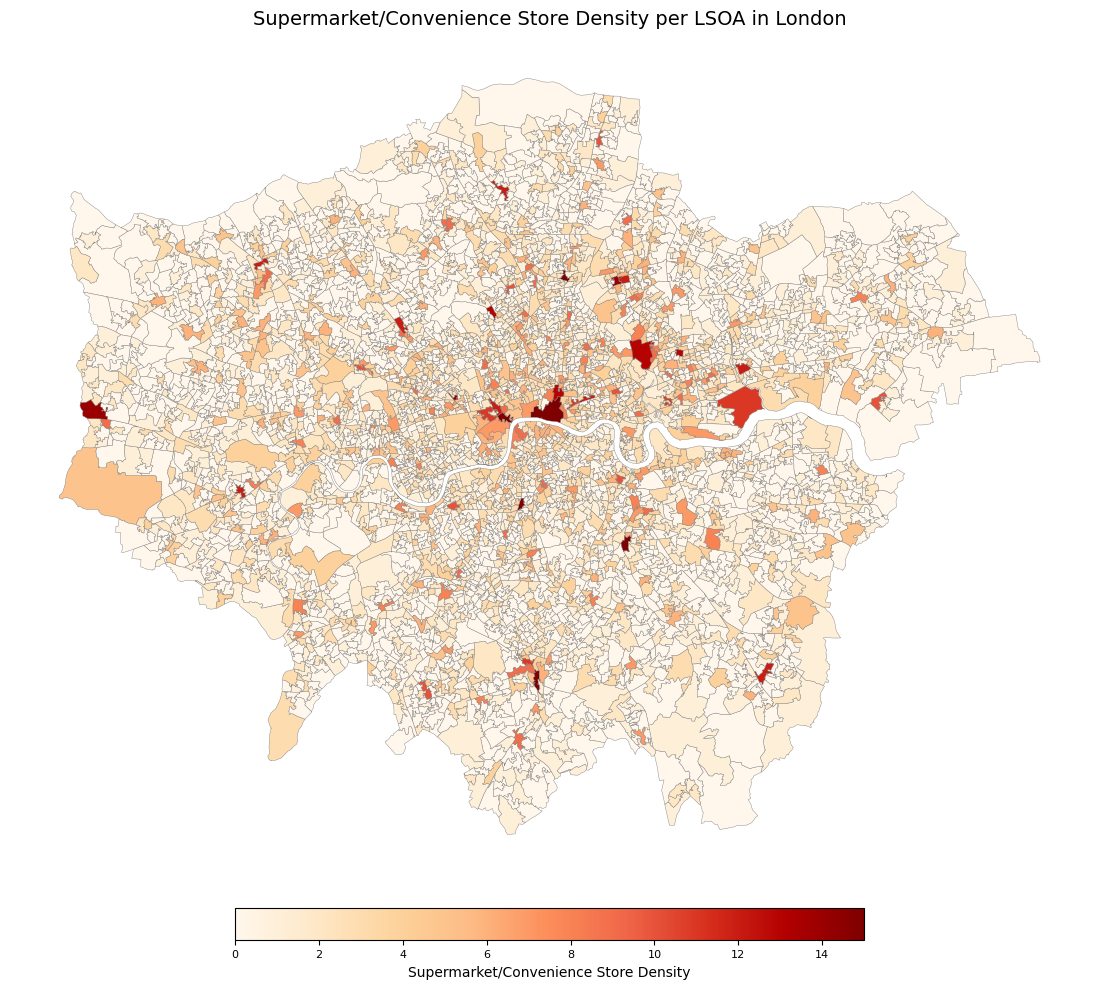

<Figure size 640x480 with 0 Axes>

In [114]:
lsoa = gpd.read_file("LSOA_2011_London_gen_MHW.json").to_crs(epsg=3857)
gp = gpd.read_file("Supermarket + Convenience Store.geojson").to_crs(epsg=3857)

joined = gpd.sjoin(gp, lsoa, how="left", predicate="within")
gp_counts = joined.groupby("index_right").size()
lsoa["gp_count"] = gp_counts
lsoa["gp_count"] = lsoa["gp_count"].fillna(0).clip(upper=15)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
cmap = plt.cm.OrRd
vmin, vmax = 0, 15
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

lsoa.plot(column="gp_count", cmap=cmap, linewidth=0.3, edgecolor="gray", ax=ax, norm=norm)
ax.set_title("Supermarket/Convenience Store Density per LSOA in London", fontsize=14, pad=12)
ax.set_axis_off()

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.035, pad=0.04)
cbar.set_label("Supermarket/Convenience Store Density", fontsize=10)
cbar.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()



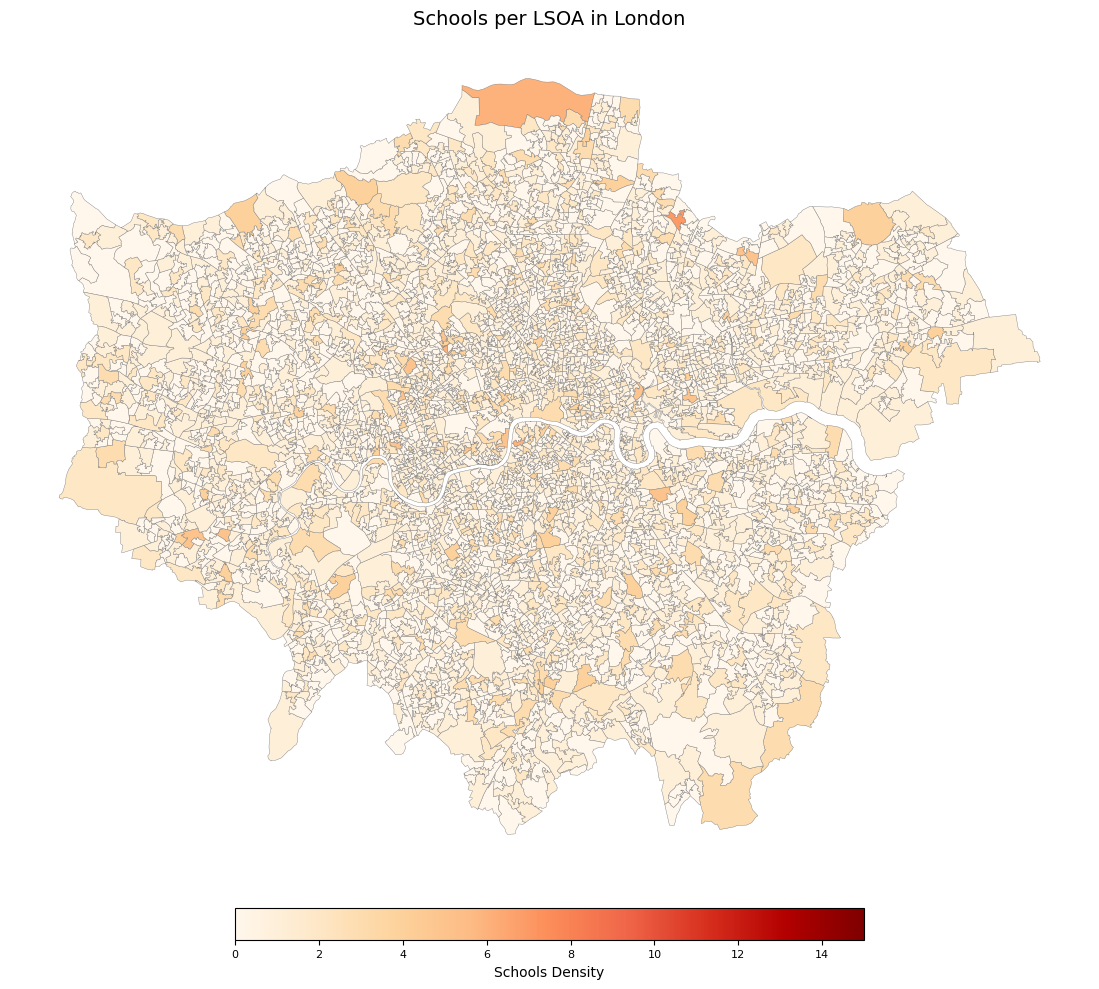

<Figure size 640x480 with 0 Axes>

In [116]:
lsoa = gpd.read_file("LSOA_2011_London_gen_MHW.json").to_crs(epsg=3857)
gp = gpd.read_file("School.geojson").to_crs(epsg=3857)

joined = gpd.sjoin(gp, lsoa, how="left", predicate="within")
gp_counts = joined.groupby("index_right").size()
lsoa["gp_count"] = gp_counts
lsoa["gp_count"] = lsoa["gp_count"].fillna(0).clip(upper=15)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
cmap = plt.cm.OrRd
vmin, vmax = 0, 15
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

lsoa.plot(column="gp_count", cmap=cmap, linewidth=0.3, edgecolor="gray", ax=ax, norm=norm)
ax.set_title("Schools per LSOA in London", fontsize=14, pad=12)
ax.set_axis_off()

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.035, pad=0.04)
cbar.set_label("Schools Density", fontsize=10)
cbar.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()



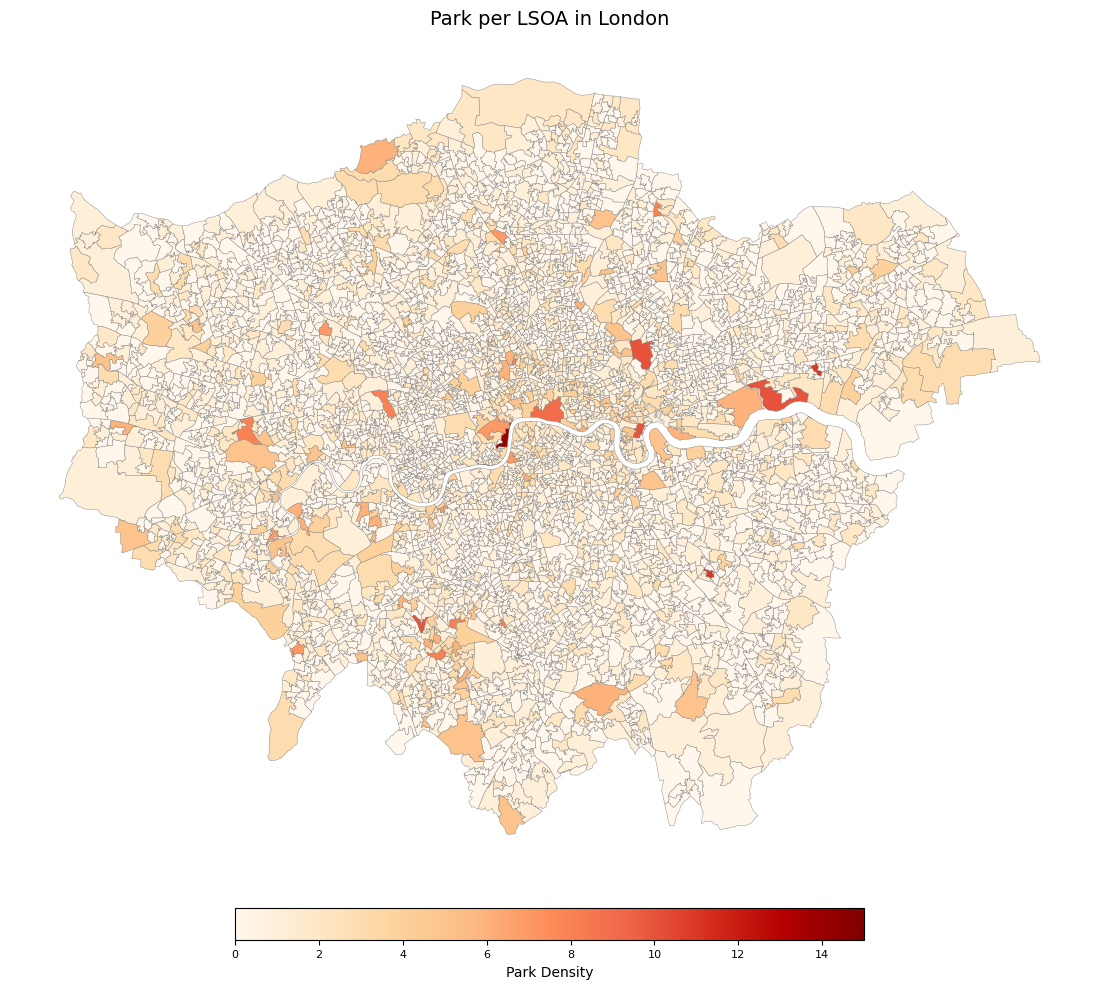

<Figure size 640x480 with 0 Axes>

In [118]:
lsoa = gpd.read_file("LSOA_2011_London_gen_MHW.json").to_crs(epsg=3857)
gp = gpd.read_file("Park.geojson").to_crs(epsg=3857)

joined = gpd.sjoin(gp, lsoa, how="left", predicate="within")
gp_counts = joined.groupby("index_right").size()
lsoa["gp_count"] = gp_counts
lsoa["gp_count"] = lsoa["gp_count"].fillna(0).clip(upper=15)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
cmap = plt.cm.OrRd
vmin, vmax = 0, 15
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

lsoa.plot(column="gp_count", cmap=cmap, linewidth=0.3, edgecolor="gray", ax=ax, norm=norm)
ax.set_title("Park per LSOA in London", fontsize=14, pad=12)
ax.set_axis_off()

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.035, pad=0.04)
cbar.set_label("Park Density", fontsize=10)
cbar.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()


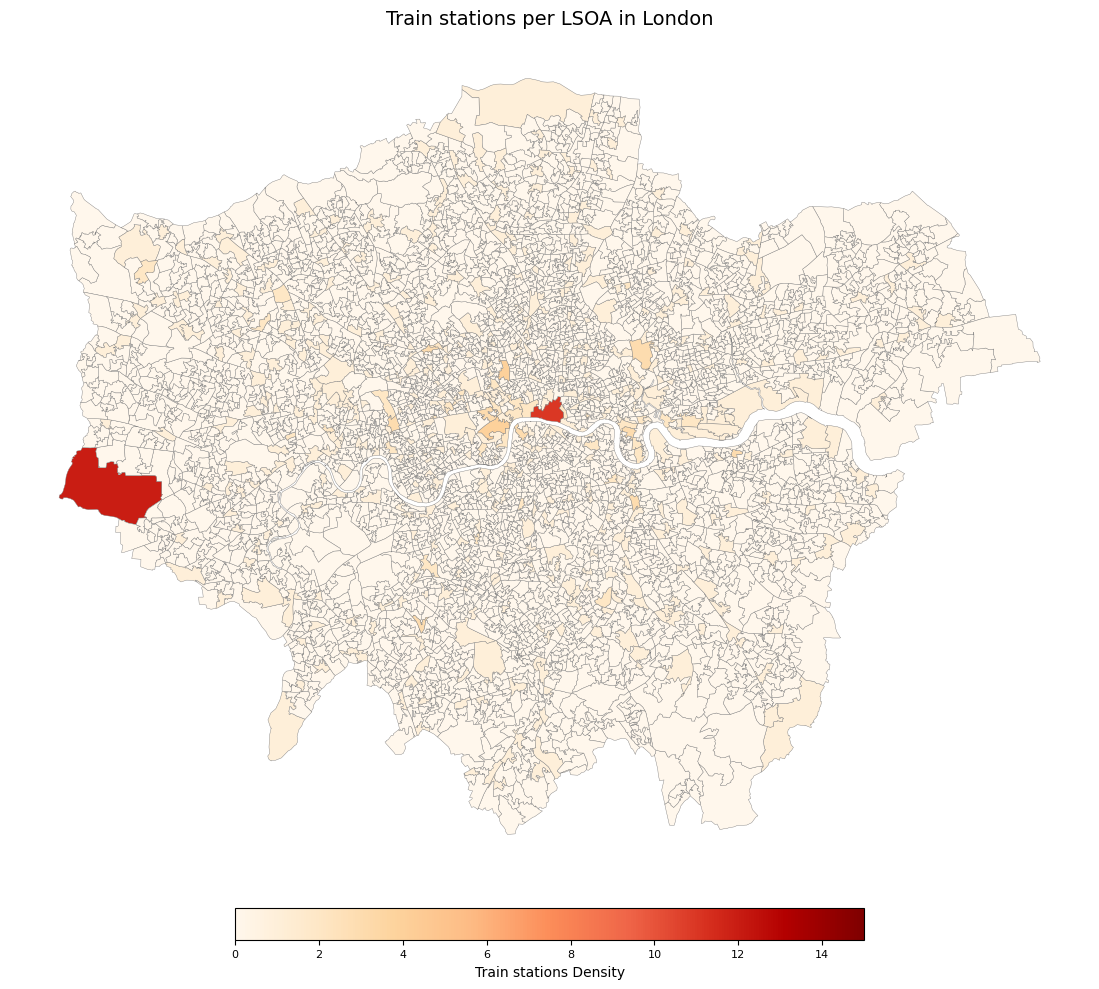

<Figure size 640x480 with 0 Axes>

In [124]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

lsoa = gpd.read_file("LSOA_2011_London_gen_MHW.json").to_crs(epsg=3857)
gp = gpd.read_file("Train _Tube Station.geojson").to_crs(epsg=3857)

joined = gpd.sjoin(gp, lsoa, how="left", predicate="within")
gp_counts = joined.groupby("index_right").size()
lsoa["gp_count"] = pd.Series(gp_counts, index=lsoa.index).fillna(0).clip(upper=15)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
cmap = plt.cm.OrRd
vmin, vmax = 0, 15
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

lsoa.plot(column="gp_count", cmap=cmap, linewidth=0.3, edgecolor="gray", ax=ax, norm=norm)
ax.set_title("Train stations per LSOA in London", fontsize=14, pad=12)
ax.set_axis_off()

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.035, pad=0.04)
cbar.set_label("Train stations Density", fontsize=10)
cbar.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()

